# Does Boderline Personality Disorder Affect the Treatment Trajectories of Patients with a Primary Diagnosis of Major Depressive Disorder?

We used multilevel modeling to investigate the treatment trejactory differences in patients with or without comorbid borderline personality disorder. 

## Load Pacakges

In [1]:
library('foreign')
library('dplyr')
library('lme4')
library('nlme')
library('merTools')
library('lmerTest')
library('ltm')
library('performance')
library('ggplot2')


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: Matrix


Attaching package: ‘nlme’


The following object is masked from ‘package:lme4’:

    lmList


The following object is masked from ‘package:dplyr’:

    collapse


Loading required package: arm

Loading required package: MASS


Attaching package: ‘MASS’


The following object is masked from ‘package:dplyr’:

    select



arm (Version 1.11-2, built: 2020-7-27)


Working directory is /Users/catcat/Desktop/GitHub/phpTxOutcome/Code/MDD_BPD_Longitudinal


Registered S3 method overwritten by 'broom.mixed':
  method      from 
  tidy.gamlss broom


Attaching package: ‘lmerTest’


The following object is masked from ‘package:lme4’:

    lmer


The following object is masked from ‘package:stats’:

    step


Loading required package: msm

Loading required package

## Load Data

In [2]:
dfLong = read.csv('../../Data/daily_dfLong.csv')
dx = read.spss('../../Data/DemosDx/Diagnosis_1.sav',to.data.frame = T)
#Ignore the undeclared levels. The sav file was not prepared by me.

Warning message in read.spss("../../Data/DemosDx/Diagnosis_1.sav", to.data.frame = T):
“../../Data/DemosDx/Diagnosis_1.sav: Long string value labels record found (record type 7, subtype 21), but ignored”
Warning message in read.spss("../../Data/DemosDx/Diagnosis_1.sav", to.data.frame = T):
“Undeclared level(s) 22 added in variable: eatnos_1”
Warning message in read.spss("../../Data/DemosDx/Diagnosis_1.sav", to.data.frame = T):
“Undeclared level(s) 10 added in variable: addhpr_1”


## Examine Data Characteristics

In [4]:
#Number of comorbid psychiatric diagnoses
dx$comorbidity = 
dx[,5:124] %>%
dplyr::select(-contains('nos'))%>% #exclude "not otherwise specified" diagnoses
mutate_all(~ifelse(grepl('Curr',.),1, 0)) %>% #focuse on "current" diagnoses 
rowSums()

In [6]:
#Find people with MDD as their principle diagnoses
dx_mddPrin = 
dx %>%
filter(grepl('Prin',mddsp_1)|grepl('Prin',mddsnp_1)|grepl('Prin', mddrp_1)|grepl('Prin',mddrnp_1))%>%
mutate(bpd = ifelse(grepl('Curr', bord_1), 1, 0))

In [7]:
#Find most prevalent cormorbid disorders
rank = 
dx_mddPrin[,5:124] %>%
dplyr::select(-contains('nos'))%>%
mutate_all(~ifelse(grepl('Curr',.),1, 0)) %>%
colSums()

dx_rank = data.frame(names(rank),  rank)
dx_rank[order(dx_rank$rank,decreasing = T),]

,names.rank.,rank
,<fct>,<dbl>
mddrnp_1,mddrnp_1,2706
gad4_1,gad4_1,1603
ptsd4_1,ptsd4_1,999
bord_1,bord_1,672
socal4_1,socal4_1,670
mddsnp_1,mddsnp_1,361
dysth_1,dysth_1,352
pda_1,pda_1,339
panic_1,panic_1,299


In [8]:
#Merge daily data with dx
dfLongMDD = merge(dfLong, dx_mddPrin, by = 'ID1',all = F,no.dups = TRUE)

dfLongMDD = dfLongMDD[order(dfLongMDD$ID1, dfLongMDD$day),]
length(unique(dfLongMDD$ID)) #1667

[1] 1667

## Descriptive Stats

In [10]:
#First sessino info
first_session = 
dfLongMDD %>%
    group_by(ID1) %>%
    filter(row_number() == 1) %>%
    ungroup()


In [12]:
#Examine Treatment Completion Rate
table(first_session$DC_status_1) #Treatment Completion N = 1087
table(first_session$DC_status_1)/nrow(first_session)*100 #65.21%


                                                      0 
                                                      0 
                                                     11 
                                                     17 
                                                     12 
                                                      7 
Inappropriate (language)/Referred to another tx setting 
                                                     18 
                           Insurance no longer covering 
                                                     22 
                                          Nonattendance 
                                                    199 
                                                  Other 
                                                     30 
                                    Other_duplicated_10 
                                                     10 
                 Reported dissatisfaction, withdrew AMA 
                              


                                                      0 
                                               0.000000 
                                                     11 
                                               1.019796 
                                                     12 
                                               0.419916 
Inappropriate (language)/Referred to another tx setting 
                                               1.079784 
                           Insurance no longer covering 
                                               1.319736 
                                          Nonattendance 
                                              11.937612 
                                                  Other 
                                               1.799640 
                                    Other_duplicated_10 
                                               0.599880 
                 Reported dissatisfaction, withdrew AMA 
                              

In [15]:
#Treatment Completion Rate by BPD status
table(first_session$DC_status_1, first_session$bpd)

#Treatment Completion Rate by BPD status (dichotomized completion status)
table(ifelse(first_session$DC_status_1 == 'Treatment Complete','Complete','Incomplete'), first_session$bpd)

#Losgitic regression
summary(glm(ifelse(first_session$DC_status_1 == 'Treatment Complete',1,0) ~first_session$bpd, family = 'binomial'))


                                                         
                                                            0   1
  0                                                         0   0
  11                                                        8   9
  12                                                        5   2
  Inappropriate (language)/Referred to another tx setting  13   5
  Insurance no longer covering                             17   5
  Nonattendance                                           144  55
  Other                                                    28   2
  Other_duplicated_10                                       6   4
  Reported dissatisfaction, withdrew AMA                   32   7
  Transferred to inpatient                                 39  30
  Treatment Complete                                      893 194
  Treatment nearly complete                                45  12
  Withdrew due to external limitations                     91  21

            
               0   1
  Complete   893 194
  Incomplete 428 152


Call:
glm(formula = ifelse(first_session$DC_status_1 == "Treatment Complete", 
    1, 0) ~ first_session$bpd, family = "binomial")

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.5013  -1.5013   0.8849   0.8849   1.0757  

Coefficients:
                  Estimate Std. Error z value Pr(>|z|)    
(Intercept)        0.73546    0.05879  12.510  < 2e-16 ***
first_session$bpd -0.49149    0.12325  -3.988 6.67e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 2154.3  on 1666  degrees of freedom
Residual deviance: 2138.6  on 1665  degrees of freedom
AIC: 2142.6

Number of Fisher Scoring iterations: 4


MDD Patients with BPD had a signficantly lower odds in completeing treatment

In [16]:
#Treatment Completion Rate by # of Comorbidities
summary(glm(ifelse(first_session$DC_status_1 == 'Treatment Complete',1,0) ~ first_session$comorbidity, family = 'binomial'))



Call:
glm(formula = ifelse(first_session$DC_status_1 == "Treatment Complete", 
    1, 0) ~ first_session$comorbidity, family = "binomial")

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.5252  -1.4287   0.9050   0.9251   1.0726  

Coefficients:
                          Estimate Std. Error z value Pr(>|z|)    
(Intercept)                0.78838    0.11301   6.976 3.03e-12 ***
first_session$comorbidity -0.05368    0.03351  -1.602    0.109    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 2154.3  on 1666  degrees of freedom
Residual deviance: 2151.7  on 1665  degrees of freedom
AIC: 2155.7

Number of Fisher Scoring iterations: 4


Number of comorbidiy does not linearly related to the odds of completion rate

In [17]:
#Create complete sample
completeSample = first_session[first_session$DC_status_1 == 'Treatment Complete',]

In [19]:
#How many people were SCID'd in the complete sample
completeSample$SCID_1[completeSample$SCID_1==2] = 'yes'

table(completeSample$SCID_1)
table(completeSample$SCID_1)/sum(table(completeSample$SCID_1))


  2  no yes 
  0 860 227 


        2        no       yes 
0.0000000 0.7911684 0.2088316 

In [21]:
#How many people had comorbid BPD in the complete sample
table(completeSample$bpd)

194/(893+194)


  0   1 
893 194 

[1] 0.1784729

In [22]:
#Comorbidity rates in the complete sample 
table(completeSample$comorbidity)
mean(completeSample$comorbidity) #Mean number of comorbid psychiatric diagnoses: 2.75
sd(completeSample$comorbidity) #SD: 1.50


  0   1   2   3   4   5   6   7   8   9  10 
  7 160 323 270 181  79  40  19   4   3   1 

[1] 2.922723

[1] 1.49816

In [23]:
#Most common comorbid psychitric diagnosis in the complete sample
rank = 
completeSample[,142:261] %>%
dplyr::select(-contains('nos'))%>%
mutate_all(~ifelse(grepl('Curr',.),1, 0)) %>%
colSums()

dx_rank = data.frame(names(rank),  rank, rank/nrow(completeSample))
dx_rank[order(dx_rank$rank,decreasing = T),][1:10,]

,names.rank.,rank,rank.nrow.completeSample.
,<fct>,<dbl>,<dbl>
mddrnp_1,mddrnp_1,891,0.81968721
gad4_1,gad4_1,479,0.44066237
ptsd4_1,ptsd4_1,283,0.26034959
bord_1,bord_1,194,0.17847286
socal4_1,socal4_1,178,0.16375345
mddsnp_1,mddsnp_1,110,0.10119595
etohab_1,etohab_1,93,0.08555658
panic_1,panic_1,92,0.08463661
pda_1,pda_1,90,0.08279669


In [24]:
#Correlation between BPD and # of cormorbidities 
cor(completeSample$bpd,completeSample$comorbidity) 

[1] 0.3786272

In [29]:
#Differences in treatment length by BPD 
completeSample$tx_length = completeSample$Days_complete_1 + completeSample$Days_not_attended_1
completeSample %>%
group_by(bpd) %>%
summarize(mean = mean(tx_length), sd = sd(tx_length))

t.test(completeSample$tx_length[completeSample$bpd == 0],
      completeSample$tx_length[completeSample$bpd == 1])


`summarise()` ungrouping output (override with `.groups` argument)



bpd,mean,sd
<dbl>,<dbl>,<dbl>
0,11.23068,5.168298
1,14.45876,11.007809



	Welch Two Sample t-test

data:  completeSample$tx_length[completeSample$bpd == 0] and completeSample$tx_length[completeSample$bpd == 1]
t = -3.9901, df = 211.82, p-value = 9.098e-05
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -4.822836 -1.633323
sample estimates:
mean of x mean of y 
 11.23068  14.45876 


Significant differences in required treatment length between MDD patients with and without BPD.

In [32]:
#Differences in comorbidities by BPD
completeSample %>%
group_by(bpd) %>%
summarize(mean = mean(comorbidity), sd = sd(comorbidity))

t.test(completeSample$comorbidity[completeSample$bpd == 0],
      completeSample$comorbidity[completeSample$bpd == 1])


#completeSample$tx_attendence_rate = completeSample$Days_complete_1/completeSample$tx_length
#summary(lm(tx_length ~bpd + comorbidity, completeSample)) #Both BPD and Comorbidities predicted longer treatment length in tx completion sample
#summary(lm(tx_attendence_rate ~bpd + comorbidity , completeSample)) #BPD does not predicted attendence rate, while # of comorbidities predicted lower attendence rate

`summarise()` ungrouping output (override with `.groups` argument)



bpd,mean,sd
<dbl>,<dbl>,<dbl>
0,2.658455,1.374344
1,4.139175,1.445454



	Welch Two Sample t-test

data:  completeSample$comorbidity[completeSample$bpd == 0] and completeSample$comorbidity[completeSample$bpd == 1]
t = -13.045, df = 273.97, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -1.704187 -1.257254
sample estimates:
mean of x mean of y 
 2.658455  4.139175 


Patients with comorbidi BPD showed significantly higher numbers of comorbidity psychiatric diagnoses.

In [34]:
#Inital Severity
completeSample %>% 
summarize(depM = mean(depMean, na.rm = T), depSD = sd(depMean, na.rm = T), #depression
         anxM = mean(anxMean, na.rm = T), anxSD = sd(anxMean, na.rm = T), #anxiety
         angM = mean(angMean, na.rm = T), angSD = sd(angMean, na.rm = T)) #anger

depM,depSD,anxM,anxSD,angM,angSD
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
3.404691,0.7168148,3.1307,0.8878087,2.244165,0.9634773


## Demographics

In [36]:
#Sex
table(completeSample$Gender_1)
table(completeSample$Gender_1)/nrow(completeSample)
nrow(completeSample)
0.003679853 + 0.005519779 


                                         Female 
                                            720 
                                           Male 
                                            347 
                                     Non-Binary 
                                              4 
                                          Other 
                                              6 
Unknown (ID as Trans Before Demos Change 12.18) 
                                              9 


                                         Female 
                                    0.662373505 
                                           Male 
                                    0.319227231 
                                     Non-Binary 
                                    0.003679853 
                                          Other 
                                    0.005519779 
Unknown (ID as Trans Before Demos Change 12.18) 
                                    0.008279669 

[1] 1087

[1] 0.009199632

In [38]:
#Age
mean(completeSample$Age_1)
sd(completeSample$Age_1)
range(completeSample$Age_1)

[1] 40.36523

[1] 14.25956

[1] 18 88

In [27]:
#Race
table(completeSample$Race_1)
table(completeSample$Race_1)/nrow(completeSample)



     Asian      Black   Hispanic      Other Portuguese      White 
        15         79        126         45         26        795 


     Asian      Black   Hispanic      Other Portuguese      White 
0.01379945 0.07267709 0.11591536 0.04139834 0.02391904 0.73137075 

In [44]:
#MDD Patients who completed treatment in long format 
dfLongMDDComplete = dfLongMDD[dfLongMDD$DC_status_1 == 'Treatment Complete',]
length(unique(dfLongMDDComplete$ID)) #N = 1087
length(unique(dfLongMDDComplete[dfLongMDDComplete$bpd == 1, 'ID1'])) #194 patients with comorbid BPD

#Treatment length
dfLongMDDComplete$txlength = dfLongMDDComplete$Days_complete_1 + dfLongMDDComplete$Days_not_attended_1


[1] 1087

[1] 194

In [54]:
#Treatment Success Rate 

#Patients with cormorbid BPD who came in with moderate to severe MDD (N = 158)
dfLongMDDComplete %>%
filter(day == 0 & bpd == 1)%>%
summarize(score = depMean*16 + dep17 + dep18) %>% #Sum score of CUDOS
summarize(ifelse(score >= 21, 1, 0))%>% #cut off socre of mild depression
colSums(na.rm = T) 

#Patients with cormorbid BPD who remained moderately to severely depressed on the average discharge (N =54)
dfLongMDDComplete %>%
filter(day == 12 & bpd == 1)%>%
summarize(score = depMean*16 + dep17 + dep18) %>%
summarize(ifelse(score >= 21, 1, 0))%>%
colSums(na.rm = T)

#Patients with cormorbid BPD who remained moderately to severely depressed on the expended discharge date (N =28)
dfLongMDDComplete %>%
filter(day == 15 & bpd == 1)%>%
summarize(score = depMean*16 + dep17 + dep18) %>%
summarize(ifelse(score >= 21, 1, 0))%>%
colSums(na.rm = T)


ifelse(score >= 21, 1, 0) 
                      158

ifelse(score >= 21, 1, 0) 
                       54

ifelse(score >= 21, 1, 0) 
                       28

In [43]:
#Improvement in success rate by three days
(54-28)/158

[1] 0.164557

## Between-Group Differences

In [45]:
#Function for mean and Se
meanSE = function(x){
    paste0(round(x$coefficient['bpd','Estimate'],2), ' (',
       round(x$coefficient['bpd','Std. Error'],2) ,')')
    
}

In [51]:
#Pre-Treatment Data
dfLongMDDComplete_Session1 = 
    dfLongMDDComplete %>%
    filter(day == 0)

#Pre-Treatment Depressive Symptoms
pre_dep_comp = summary(lmer(depMean ~ bpd + (1|uniquePtId), dfLongMDDComplete_Session1))
pre_dep_comp

#Pre-Treatment Functionality
pre_fun_comp = summary(lmer(dep17 ~ bpd + (1|uniquePtId), dfLongMDDComplete_Session1))
pre_fun_comp

#Pre-Treatment Well-Being
pre_well_comp = summary(lmer(dep18 ~ bpd + (1|uniquePtId), dfLongMDDComplete_Session1))
pre_well_comp

table1 = c()
table1 = cbind(table1, pre = c(meanSE(pre_dep_comp), meanSE(pre_fun_comp), meanSE(pre_well_comp)))
table1

#Comorbidity
summary(lmer(comorbidity ~ bpd + (1|uniquePtId), dfLongMDDComplete_Session1))

#Treatment Length
summary(lmer(txlength ~ bpd + (1|uniquePtId), dfLongMDDComplete_Session1))



Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: depMean ~ bpd + (1 | uniquePtId)
   Data: dfLongMDDComplete_Session1

REML criterion at convergence: 2037.5

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.2707 -0.4691  0.0832  0.6271  2.2671 

Random effects:
 Groups     Name        Variance Std.Dev.
 uniquePtId (Intercept) 0.112    0.3347  
 Residual               0.391    0.6253  
Number of obs: 949, groups:  uniquePtId, 795

Fixed effects:
             Estimate Std. Error        df t value Pr(>|t|)    
(Intercept)   3.37059    0.02605 780.53138 129.367  < 2e-16 ***
bpd           0.19427    0.06130 940.46308   3.169  0.00158 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
    (Intr)
bpd -0.394

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: dep17 ~ bpd + (1 | uniquePtId)
   Data: dfLongMDDComplete_Session1

REML criterion at convergence: 2887.2

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.6966 -0.6394  0.1894  0.9550  1.3206 

Random effects:
 Groups     Name        Variance Std.Dev.
 uniquePtId (Intercept) 0.1571   0.3963  
 Residual               1.1199   1.0582  
Number of obs: 936, groups:  uniquePtId, 786

Fixed effects:
             Estimate Std. Error        df t value Pr(>|t|)    
(Intercept)   3.77150    0.04135 689.62936  91.206   <2e-16 ***
bpd           0.14665    0.09876 878.37203   1.485    0.138    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
    (Intr)
bpd -0.401

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: dep18 ~ bpd + (1 | uniquePtId)
   Data: dfLongMDDComplete_Session1

REML criterion at convergence: 2396

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.8654 -0.6152  0.3000  0.4400  1.8631 

Random effects:
 Groups     Name        Variance Std.Dev.
 uniquePtId (Intercept) 0.1140   0.3376  
 Residual               0.6503   0.8064  
Number of obs: 932, groups:  uniquePtId, 783

Fixed effects:
             Estimate Std. Error        df t value Pr(>|t|)    
(Intercept)   3.58304    0.03215 786.01669 111.442   <2e-16 ***
bpd           0.13265    0.07663 910.88426   1.731   0.0838 .  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
    (Intr)
bpd -0.399

pre
0.19 (0.06)
0.15 (0.1)
0.13 (0.08)


Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: comorbidity ~ bpd + (1 | uniquePtId)
   Data: dfLongMDDComplete_Session1

REML criterion at convergence: 3722.1

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.0536 -0.4424 -0.1150  0.5197  4.8250 

Random effects:
 Groups     Name        Variance Std.Dev.
 uniquePtId (Intercept) 0.3047   0.552   
 Residual               1.6406   1.281   
Number of obs: 1063, groups:  uniquePtId, 877

Fixed effects:
             Estimate Std. Error        df t value Pr(>|t|)    
(Intercept)    2.6719     0.0483  913.4841   55.32   <2e-16 ***
bpd            1.4471     0.1128 1044.7525   12.83   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
    (Intr)
bpd -0.400

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: txlength ~ bpd + (1 | uniquePtId)
   Data: dfLongMDDComplete_Session1

REML criterion at convergence: 7030.5

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.6469 -0.6169 -0.1791  0.4046 13.9747 

Random effects:
 Groups     Name        Variance Std.Dev.
 uniquePtId (Intercept)  2.991   1.729   
 Residual               40.756   6.384   
Number of obs: 1063, groups:  uniquePtId, 877

Fixed effects:
             Estimate Std. Error        df t value Pr(>|t|)    
(Intercept)   11.2276     0.2266  997.0100   49.56  < 2e-16 ***
bpd            3.0556     0.5333 1041.5395    5.73 1.32e-08 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
    (Intr)
bpd -0.412

In [52]:
#Post-Treatment Data
dfLongMDDComplete_SessionF = 
    dfLongMDDComplete %>%
    group_by(ID1) %>%
    slice(day = max(day))%>%
    ungroup() 

#Post-Treatment Depressive Symptoms
post_dep_comp = summary(lmer(depMean ~ bpd + (1|uniquePtId), dfLongMDDComplete_SessionF))
post_dep_comp

#Post-Treatment Functionality
post_fun_comp = summary(lmer(dep17 ~ bpd + (1|uniquePtId), dfLongMDDComplete_SessionF))
post_fun_comp

#Post-Treatment Well-Being
post_well_comp  = summary(lmer(dep18 ~ bpd + (1|uniquePtId), dfLongMDDComplete_SessionF))
post_well_comp 

table1 = cbind(table1, post = c(meanSE(post_dep_comp), meanSE(post_fun_comp), meanSE(post_well_comp)))
table1

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: depMean ~ bpd + (1 | uniquePtId)
   Data: dfLongMDDComplete_SessionF

REML criterion at convergence: 1653.4

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.6228 -0.6854 -0.1110  0.6003  3.7688 

Random effects:
 Groups     Name        Variance Std.Dev.
 uniquePtId (Intercept) 0.1762   0.4198  
 Residual               0.5575   0.7466  
Number of obs: 654, groups:  uniquePtId, 574

Fixed effects:
             Estimate Std. Error        df t value Pr(>|t|)    
(Intercept)   2.29659    0.03752 603.26514  61.204   <2e-16 ***
bpd           0.06438    0.08878 651.55843   0.725    0.469    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
    (Intr)
bpd -0.394

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: dep17 ~ bpd + (1 | uniquePtId)
   Data: dfLongMDDComplete_SessionF

REML criterion at convergence: 1974.2

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.7239 -0.5987  0.1275  0.9084  2.1860 

Random effects:
 Groups     Name        Variance Std.Dev.
 uniquePtId (Intercept) 0.2634   0.5132  
 Residual               1.0466   1.0231  
Number of obs: 635, groups:  uniquePtId, 560

Fixed effects:
             Estimate Std. Error        df t value Pr(>|t|)    
(Intercept)   2.76658    0.05077 581.47592  54.489   <2e-16 ***
bpd           0.07019    0.12060 632.36424   0.582    0.561    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
    (Intr)
bpd -0.399

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: dep18 ~ bpd + (1 | uniquePtId)
   Data: dfLongMDDComplete_SessionF

REML criterion at convergence: 1680.6

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.9647 -0.8282  0.1024  0.3841  2.2899 

Random effects:
 Groups     Name        Variance Std.Dev.
 uniquePtId (Intercept) 0.2419   0.4918  
 Residual               0.5679   0.7536  
Number of obs: 641, groups:  uniquePtId, 564

Fixed effects:
             Estimate Std. Error        df t value Pr(>|t|)    
(Intercept)   2.88997    0.03998 594.86250  72.292   <2e-16 ***
bpd           0.10485    0.09311 634.35375   1.126    0.261    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
    (Intr)
bpd -0.394

pre,post
0.19 (0.06),0.06 (0.09)
0.15 (0.1),0.07 (0.12)
0.13 (0.08),0.1 (0.09)


In [53]:
#Change Data
dfLongMDDComplete_Change = 
    dfLongMDDComplete %>%
    group_by(ID1) %>%
    summarize(bpd = bpd[1],
    depMeanC = depMean[n()] - depMean[1],
    dep17C = dep17[n()]-dep17[1],
    dep18C = dep18[n()]-dep18[1],
    SCID_1 = SCID_1[1],
    uniquePtId = uniquePtId[1]) %>%
    ungroup()

#Change Depressive Symptoms
change_dep_comp = summary(lmer(depMeanC ~ bpd + (1|uniquePtId), dfLongMDDComplete_Change))
change_dep_comp

#Change Functionality
change_fun_comp = summary(lmer(dep17C ~ bpd + (1|uniquePtId), dfLongMDDComplete_Change))
change_fun_comp

#Change Well-Being
change_well_comp = summary(lmer(dep18C ~ bpd + (1|uniquePtId), dfLongMDDComplete_Change))
change_well_comp

table1 = cbind(table1, change = c(meanSE(change_dep_comp), meanSE(change_fun_comp), meanSE(change_well_comp)))
table1

`summarise()` ungrouping output (override with `.groups` argument)



Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: depMeanC ~ bpd + (1 | uniquePtId)
   Data: dfLongMDDComplete_Change

REML criterion at convergence: 1652.4

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-2.27967 -0.65209 -0.04099  0.64997  3.12388 

Random effects:
 Groups     Name        Variance Std.Dev.
 uniquePtId (Intercept) 0.1538   0.3922  
 Residual               0.5727   0.7568  
Number of obs: 656, groups:  uniquePtId, 563

Fixed effects:
             Estimate Std. Error        df t value Pr(>|t|)    
(Intercept)  -1.18648    0.03762 580.23704 -31.536   <2e-16 ***
bpd          -0.02155    0.08639 653.98471  -0.249    0.803    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
    (Intr)
bpd -0.408

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: dep17C ~ bpd + (1 | uniquePtId)
   Data: dfLongMDDComplete_Change

REML criterion at convergence: 2129.2

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.2020 -0.6520  0.1028  0.8576  3.2408 

Random effects:
 Groups     Name        Variance Std.Dev.
 uniquePtId (Intercept) 0.06313  0.2513  
 Residual               1.62666  1.2754  
Number of obs: 632, groups:  uniquePtId, 547

Fixed effects:
             Estimate Std. Error        df t value Pr(>|t|)    
(Intercept)  -1.13621    0.05751 535.23635 -19.755   <2e-16 ***
bpd          -0.15662    0.13394 601.55564  -1.169    0.243    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
    (Intr)
bpd -0.424

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: dep18C ~ bpd + (1 | uniquePtId)
   Data: dfLongMDDComplete_Change

REML criterion at convergence: 1836.4

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.8287 -0.3883 -0.1800  0.7029  4.2345 

Random effects:
 Groups     Name        Variance Std.Dev.
 uniquePtId (Intercept) 0.1632   0.4039  
 Residual               0.9278   0.9632  
Number of obs: 627, groups:  uniquePtId, 542

Fixed effects:
             Estimate Std. Error        df t value Pr(>|t|)    
(Intercept)  -0.79613    0.04687 550.57286 -16.987   <2e-16 ***
bpd          -0.08994    0.10879 620.22368  -0.827    0.409    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
    (Intr)
bpd -0.412

In [54]:
table1

pre,post,change
0.19 (0.06),0.06 (0.09),-0.02 (0.09)
0.15 (0.1),0.07 (0.12),-0.16 (0.13)
0.13 (0.08),0.1 (0.09),-0.09 (0.11)


In [56]:
#function to retrive mean and sd
mean_sd = function(x){
    return(paste0(round(mean(x, na.rm = T),2), ' (',round(sd(x, na.rm = T),2),')'))
    
}

In [57]:
mean_sdc = 
dfLongMDDComplete %>%
group_by(ID1) %>%
summarize(bpd = bpd[1],
          depMean1 = depMean[1],
          dep171 = dep17[1],
          dep181 = dep18[1],
          depMeanF = depMean[n()],
          dep17F = dep17[n()],
          dep18F = dep18[n()],
         depMeanC = depMean[n()] - depMean[1],
         dep17C = dep17[n()]-dep17[1],
         dep18c = dep18[n()]-dep18[1],
         comorbidity = comorbidity[1],
         txlength = txlength[1]) %>%
ungroup()%>%
dplyr::select(-ID1)%>%
group_by(bpd) %>%
summarize_all(mean_sd) %>%
t()

mean_sdc


`summarise()` ungrouping output (override with `.groups` argument)



bpd,0,1
depMean1,3.37 (0.71),3.59 (0.73)
dep171,3.78 (1.14),3.95 (1.07)
dep181,3.59 (0.88),3.74 (0.8)
depMeanF,2.25 (0.84),2.39 (0.89)
dep17F,2.71 (1.16),2.79 (1.21)
dep18F,2.86 (0.9),2.98 (1.02)
depMeanC,-1.18 (0.82),-1.2 (0.99)
dep17C,-1.14 (1.28),-1.29 (1.38)
dep18c,-0.8 (1.04),-0.89 (1.05)
comorbidity,2.66 (1.37),4.14 (1.45)


## Longitudinal Analysis/Multilevel Modeling

In [76]:
#ICC
base_dep = lmer(depMean~ 1 + (1|uniquePtId:ID1), data = dfLongMDDComplete)
icc(base_dep, dfLongMDDComplete)

base_fun = lmer(dep17~ 1 + (1|uniquePtId:ID1), data = dfLongMDDComplete)
icc(base_fun, dfLongMDDComplete)

base_well = lmer(dep18~ 1 + (1|uniquePtId:ID1), data = dfLongMDDComplete)
icc(base_well, dfLongMDDComplete)

# Intraclass Correlation Coefficient

     Adjusted ICC: 0.588
  Conditional ICC: 0.588

# Intraclass Correlation Coefficient

     Adjusted ICC: 0.526
  Conditional ICC: 0.526

# Intraclass Correlation Coefficient

     Adjusted ICC: 0.515
  Conditional ICC: 0.515

In [60]:
#Predcit changes in depression with bpd while controling for txlength
print('Symptom reduction')
sum_sym = summary(lmer(depMean ~ day*bpd + (1|uniquePtId)+ (1+day|uniquePtId:ID1), data = dfLongMDDComplete)) 
sum_sym$coefficients

print('Functionoing')
sum_fun = summary(lmer(dep17 ~ day*bpd + (1|uniquePtId)+ (1+day|uniquePtId:ID1), data = dfLongMDDComplete))
sum_fun$coefficients

print('Wellbeing')
sum_well = summary(lmer(dep18 ~ day*bpd + (1|uniquePtId)+ (1+day|uniquePtId:ID1), data = dfLongMDDComplete))
sum_well$coefficients

[1] "Symptom reduction"


,Estimate,Std. Error,df,t value,Pr(>|t|)
(Intercept),3.06671728,0.025258372,869.1783,121.413895,0.000000e+00
day,-0.11447574,0.003835685,628.8810,-29.844930,1.369742e-122
bpd,0.22402399,0.059645018,987.4762,3.755955,1.827820e-04
day:bpd,0.01895975,0.008981255,556.5013,2.111036,3.521458e-02


[1] "Functionoing"


,Estimate,Std. Error,df,t value,Pr(>|t|)
(Intercept),3.54211829,0.036397556,896.0899,97.317475,0.000000e+00
day,-0.10121698,0.004662517,580.6867,-21.708657,5.873550e-77
bpd,0.14727799,0.084593430,971.4401,1.741010,8.199845e-02
day:bpd,0.01546846,0.010603076,475.1789,1.458865,1.452629e-01


[1] "Wellbeing"


Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model failed to converge with max|grad| = 0.00372289 (tol = 0.002, component 1)”


,Estimate,Std. Error,df,t value,Pr(>|t|)
(Intercept),3.44068371,0.027231927,925.0889,126.347420,0.000000e+00
day,-0.06787569,0.003471911,548.1964,-19.549951,5.690854e-65
bpd,0.12016096,0.063487581,975.0108,1.892669,5.869793e-02
day:bpd,0.01102554,0.007849589,439.7864,1.404601,1.608459e-01


In [63]:
#Calculate pseudo R2
model = lmer(depMean ~ day*(bpd) + (1|uniquePtId)+ (1+day|uniquePtId:ID1), data = dfLongMDDComplete)
predicted <- predict(model, dfLongMDDComplete, allow.new.levels = T)
1-sum((dfLongMDDComplete$depMean -predicted)^2, na.rm = T)/(var(dfLongMDDComplete$depMean, na.rm = T)*nrow(dfLongMDDComplete)-1)

[1] 0.8521642

In [64]:
#Chronbach's Alpha
cronbach.alpha(dfLongMDDComplete[dfLongMDDComplete$day == 0,
                                 grep('^dep[0-9]*$', colnames(dfLongMDDComplete))], na.rm = T)



Cronbach's alpha for the 'dfLongMDDComplete[dfLongMDDComplete$day == 0, grep("^dep[0-9]*$", ' '    colnames(dfLongMDDComplete))]' data-set

Items: 18
Sample units: 1063
alpha: 0.855


In [36]:
#Predcit changes in depression with bpd and comorbidities while controling for txlength

print('Symptom reduction')
sum_dep_co = summary(lmer(depMean ~ day*(bpd+comorbidity) + (1|uniquePtId)+ (1+day|uniquePtId:ID1), data = dfLongMDDComplete)) 
sum_dep_co$coefficients

print('Functionoing')
sum_fun_co = summary(lmer(dep17 ~ day*(bpd+comorbidity) +  (1|uniquePtId)+ (1+day|uniquePtId:ID1), data = dfLongMDDComplete))
sum_fun_co$coefficients

print('Wellbeing')
sum_well_co = summary(lmer(dep18 ~ day*(bpd+comorbidity) +  (1|uniquePtId)+ (1+day|uniquePtId:ID1), data = dfLongMDDComplete))
sum_well_co$coefficients

[1] "Symptom reduction"


,Estimate,Std. Error,df,t value,Pr(>|t|)
(Intercept),2.860379181,0.049503460,1013.1567,57.7813992,5.928788e-323
day,-0.135325270,0.007731907,630.2149,-17.5021844,3.409925e-56
bpd,0.114133457,0.063271369,996.1231,1.8038721,7.155337e-02
comorbidity,0.077295318,0.015963855,1015.8819,4.8418956,1.485902e-06
day:bpd,0.007588447,0.009610949,555.2650,0.7895627,4.301202e-01
day:comorbidity,0.007724168,0.002450547,590.0039,3.1520178,1.703719e-03


[1] "Functionoing"


Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model failed to converge with max|grad| = 0.00241969 (tol = 0.002, component 1)”


,Estimate,Std. Error,df,t value,Pr(>|t|)
(Intercept),3.232003942,0.070600506,1017.7418,45.7787644,2.370262e-249
day,-0.108372201,0.009456873,581.4171,-11.4596228,1.487053e-27
bpd,-0.015220131,0.089628615,975.4022,-0.1698133,8.651922e-01
comorbidity,0.116269828,0.022662811,999.4242,5.1304239,3.471872e-07
day:bpd,0.011838621,0.011400325,476.6991,1.0384459,2.995889e-01
day:comorbidity,0.002575504,0.002953022,528.3033,0.8721587,3.835180e-01


[1] "Wellbeing"


Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model failed to converge with max|grad| = 0.0170308 (tol = 0.002, component 1)”


,Estimate,Std. Error,df,t value,Pr(>|t|)
(Intercept),3.287208244,0.053355652,1021.7032,61.6093730,0.000000e+00
day,-0.082576769,0.007023872,546.6144,-11.7565886,1.317606e-28
bpd,0.039501858,0.067705573,976.3614,0.5834358,5.597347e-01
comorbidity,0.057593671,0.017129069,1002.0298,3.3623352,8.020879e-04
day:bpd,0.003354874,0.008412043,440.9928,0.3988180,6.902203e-01
day:comorbidity,0.005343657,0.002186782,492.1484,2.4436168,1.489109e-02


### Figure

In [77]:
model_dep = lmer(depMean ~ day*bpd + (1|uniquePtId)+ (1+day|uniquePtId:ID1), data = dfLongMDDComplete)
model_fun = lmer(dep17 ~ day*bpd + (1|uniquePtId)+ (1+day|uniquePtId:ID1), data = dfLongMDDComplete)
model_well = lmer(dep18 ~ day*bpd + (1|uniquePtId)+ (1+day|uniquePtId:ID1), data = dfLongMDDComplete)


Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model failed to converge with max|grad| = 0.00372289 (tol = 0.002, component 1)”


In [78]:
newdata = data.frame(uniquePtId = 1000, ID1 = 1000, day = c(c(0:11),c(0:14)), bpd = c(rep(0,12), rep(1,15)))

In [80]:
pred_bpd_dep = 
predictInterval(merMod = model_dep, newdata = newdata,
                        level = 0.95, n.sims = 1000, which = 'fixed',
                        stat = "median", type="linear.prediction",                        
                        include.resid.var = F)
pred_bpd_dep$var = 'Depressive\nSymptom'

pred_bpd_fun = 
predictInterval(merMod = model_fun, newdata = newdata,
                        level = 0.95, n.sims = 1000, which = 'fixed',
                        stat = "median", type="linear.prediction",                        
                        include.resid.var = F)
pred_bpd_fun$var = 'Functional\nImpairment'

pred_bpd_well = 
predictInterval(merMod = model_well, newdata = newdata,
                        level = 0.95, n.sims = 1000, which = 'fixed',
                        stat = "median", type="linear.prediction",                        
                        include.resid.var = F)
pred_bpd_well$var = 'Life\nDissatisfaction'

Warning message:
“     The following levels of uniquePtId:ID1 from newdata 
 -- NA -- are not in the model data. 
     Currently, predictions for these values are based only on the 
 fixed coefficients and the observation-level error.”
Warning message:
“     The following levels of uniquePtId from newdata 
 -- 1000 -- are not in the model data. 
     Currently, predictions for these values are based only on the 
 fixed coefficients and the observation-level error.”
Warning message:
“     The following levels of uniquePtId:ID1 from newdata 
 -- NA -- are not in the model data. 
     Currently, predictions for these values are based only on the 
 fixed coefficients and the observation-level error.”
Warning message:
“     The following levels of uniquePtId from newdata 
 -- 1000 -- are not in the model data. 
     Currently, predictions for these values are based only on the 
 fixed coefficients and the observation-level error.”
Warning message:
“     The following levels of uniquePtId:ID

In [81]:
pred_bpd = rbind(pred_bpd_dep, pred_bpd_fun, pred_bpd_well)
pred_bpd$day = c(c(0:11),c(0:14))
pred_bpd$bpd = c(rep(0,12), rep(1,15))
pred_bpd


fit,upr,lwr,var,day,bpd
<dbl>,<dbl>,<dbl>,<chr>,<int>,<dbl>
3.067082,3.118352,3.021623,Depressive Symptom,0,0
2.953209,3.000657,2.907774,Depressive Symptom,1,0
2.839009,2.887165,2.793312,Depressive Symptom,2,0
2.724823,2.775163,2.675916,Depressive Symptom,3,0
2.610864,2.663219,2.559650,Depressive Symptom,4,0
2.496461,2.550617,2.441769,Depressive Symptom,5,0
2.382147,2.438261,2.320584,Depressive Symptom,6,0
2.267736,2.327048,2.200401,Depressive Symptom,7,0
2.153690,2.219663,2.079567,Depressive Symptom,8,0


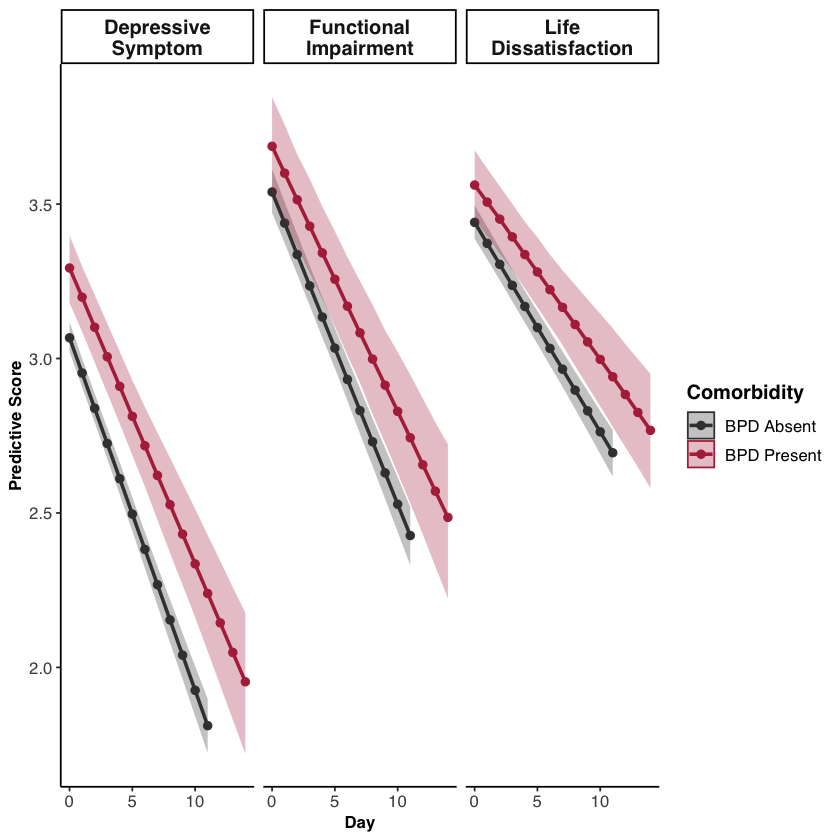

In [87]:
ggplot(pred_bpd , aes(x = day, y = fit, group = bpd, color = as.factor(bpd))) +
     geom_point(size = 2) +
     geom_ribbon(aes(ymin = lwr, ymax = upr, color = NULL, fill = as.factor(bpd)), alpha = .3) +
     geom_line(aes(y = fit), size = 1) + 
     facet_grid(~var) +
     theme_classic() + 
     xlab('Day') + 
     ylab('Predictive Score') +
     scale_color_manual('Comorbidity',values = c('#3F3F3F','#B22F4A'),labels=c("BPD Absent","BPD Present")) + 
     scale_fill_manual('Comorbidity', values = c('#3F3F3F','#B22F4A'),labels=c("BPD Absent","BPD Present")) +
     theme(
         strip.text.x = element_text(size = 12, face = 'bold'),
         title = element_text(size = 12, face = 'bold'),
         legend.text = element_text(size = 10),
         axis.title = element_text(size = 10, face = 'bold'),
         axis.text = element_text(size = 10),
         text=element_text(family="Helvetica"))
         

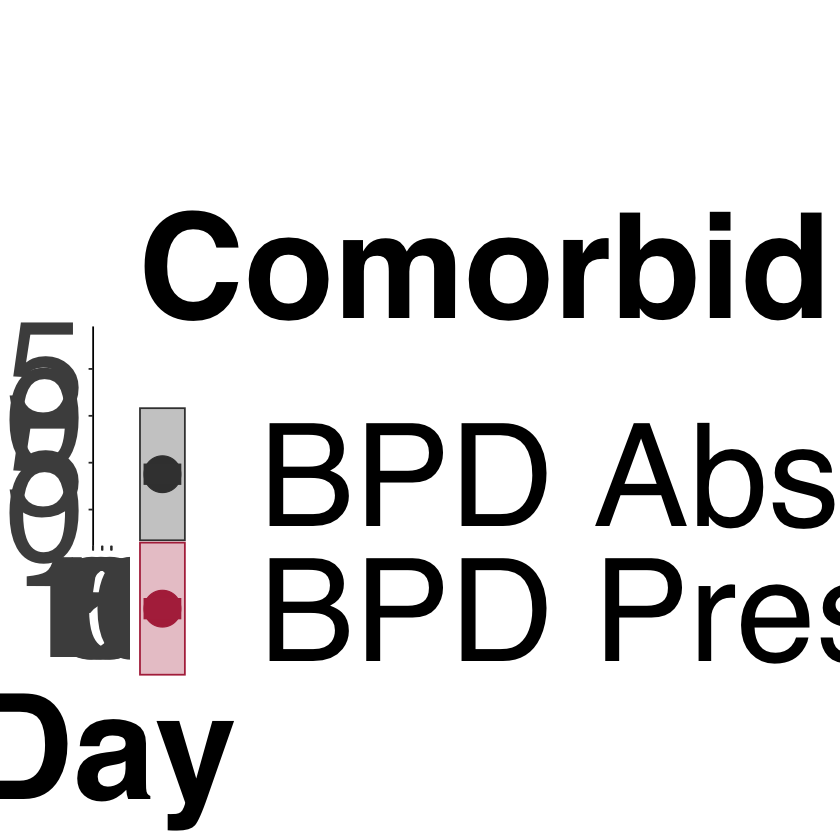

In [89]:
#Size adjustment for pdf (ignore the display)
ggplot(pred_bpd , aes(x = day, y = fit, group = bpd, color = as.factor(bpd))) +
     geom_point(size = 10) +
     geom_ribbon(aes(ymin = lwr, ymax = upr, color = NULL, fill = as.factor(bpd)), alpha = .3) +
     geom_line(aes(y = fit), size = 6) + 
     facet_grid(~var) +
     theme_classic() + 
     xlab('Day') + 
     ylab('Predictive Score') +
     scale_color_manual('Comorbidity',values = c('#3F3F3F','#B22F4A'),labels=c("BPD Absent","BPD Present")) + 
     scale_fill_manual('Comorbidity', values = c('#3F3F3F','#B22F4A'),labels=c("BPD Absent","BPD Present")) +
     theme(
         strip.text.x = element_text(size = 90, face = 'bold'),
         title = element_text(size = 88, face = 'bold'),
         legend.text = element_text(size = 86),
         axis.title = element_text(size = 88, face = 'bold'),
         axis.text = element_text(size = 86),
         text=element_text(family="Helvetica"))

ggsave(width = 40, height = 40, filename = "Results.pdf")